# Term Structure of Interest Rates

- bootstrap, splines, yield curve, duration
- Liu and Wu (2020), St Louis Fed FRED

Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os
import re
from finds.alfred import Alfred
from finds.busday import to_monthend
from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])

# Term Structure of Interest Rates
# list of monthly Constant Maturity Treasury, excluding inflation-indexed
c = alf.get_category(115)  # Fed H.15 Selected Interest Rates
print(c['id'], c['name'])
t = Series({s['id']: s['title'] for s in c['series']
            if s['frequency']=='Monthly' and 'Inflation' not in s['title']})
t.to_frame()

115 Treasury Constant Maturity


,0
GS1,1-Year Treasury Constant Maturity Rate
GS10,10-Year Treasury Constant Maturity Rate
GS1M,1-Month Treasury Constant Maturity Rate
GS2,2-Year Treasury Constant Maturity Rate
GS20,20-Year Treasury Constant Maturity Rate
GS3,3-Year Treasury Constant Maturity Rate
GS30,30-Year Treasury Constant Maturity Rate
GS3M,3-Month Treasury Constant Maturity Rate
GS5,5-Year Treasury Constant Maturity Rate
GS6M,6-Month Treasury Constant Maturity Rate


   ## retrieve CMT yields, and infer maturity from label

In [2]:
b = pd.concat([alf(s, freq='M') for s in t.index], axis=1, join='inner')
b.columns = [int(re.sub('\D', '', col)) * (1 if col.endswith('M') else 12)
             for col in b.columns]    # infer maturity in months from label
b = b.sort_index(axis=1)              # sort columns by ascending maturity
b

,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
20010731,3.67,3.59,3.56,3.62,4.04,4.31,4.76,5.06,5.24,5.75,5.61
20010831,3.53,3.44,3.39,3.47,3.76,4.04,4.57,4.84,4.97,5.58,5.48
20010930,2.68,2.69,2.71,2.82,3.12,3.45,4.12,4.51,4.73,5.53,5.48
20011031,2.27,2.20,2.17,2.33,2.73,3.14,3.91,4.31,4.57,5.34,5.32
20011130,1.99,1.91,1.92,2.18,2.78,3.22,3.97,4.42,4.65,5.33,5.12
...,...,...,...,...,...,...,...,...,...,...,...
20201031,0.09,0.10,0.11,0.13,0.15,0.19,0.34,0.55,0.79,1.34,1.57
20201130,0.09,0.09,0.10,0.12,0.17,0.22,0.39,0.63,0.87,1.40,1.62
20201231,0.08,0.09,0.09,0.10,0.14,0.19,0.39,0.66,0.93,1.47,1.67


### Helper methods for bond math

In [3]:
def pv(flow, n, spot):
    """PV of cash flow after compounding spot rate over n periods"""
    return flow / ((1 + spot) ** n)

def weighted_maturity(flows, spot, first=1, returned=False):
    """Average maturity weighted by PV of flows given effective spot rates"""
    v = [pv(flow=flow, n=n+first, spot=rate)
         for n, (flow, rate) in enumerate(zip(flows, spot))]
    return np.average(np.arange(len(v))+first, weights=v, returned=returned)

def par_duration(nominal, n, face=1, m=1, first=1):
    """Macaulay duration of a coupon par bond"""
    coupon = nominal * face  # par bond
    flows = [coupon/m]*(n*m - 1) + [face + coupon/m] 
    d,v = weighted_maturity(flows, [nominal/m]*(n*m), first=first,returned=True)
    return d / m

def forward(spot, base=0):
    """forward rate implied by spot starting after base periods"""
    return [(((1 + num)**(n + 1 + base) / (1 + den)**(n + base)) - 1)
            for n, (num, den) in enumerate(zip(spot, [0] + list(spot[:-1])))]
    
from pandas.api import types
def dcf(flows, spot, first=1):
    """PV of flows, starting at period first, by compounding associated spot"""
    if not types.is_list_like(flows):   # flows can be different each period
        flows = [flows]                 #  else assume same flow every period
    if not types.is_list_like(spot):    # spot rates can be different each flow
        spot = [spot]                   #  else use same spot rate every period
    if len(flows) == 1:
        flows = list(flows) * len(spot) # repeat flows to be same length as spot
    if len(spot) == 1:
        spot = list(spot) * len(flows)  # repeat spot to be same length as flows
    return np.sum([pv(flow=flow, n=first+n, spot=rate)
                   for n, (flow, rate) in enumerate(zip(flows, spot))])

def bootstrap(ytm, nominal, m):
    """Nominal rate to maturity of par bond from ytm and sequence of nominals"""
    n = len(nominal) + 1     # implicit # of coupons, including last at maturity
    return (((1 + ytm/m)/(1 - dcf(ytm/m, [r/m for r in nominal])))**(1/n) - 1)*m

 ## Plot yields and durations over time

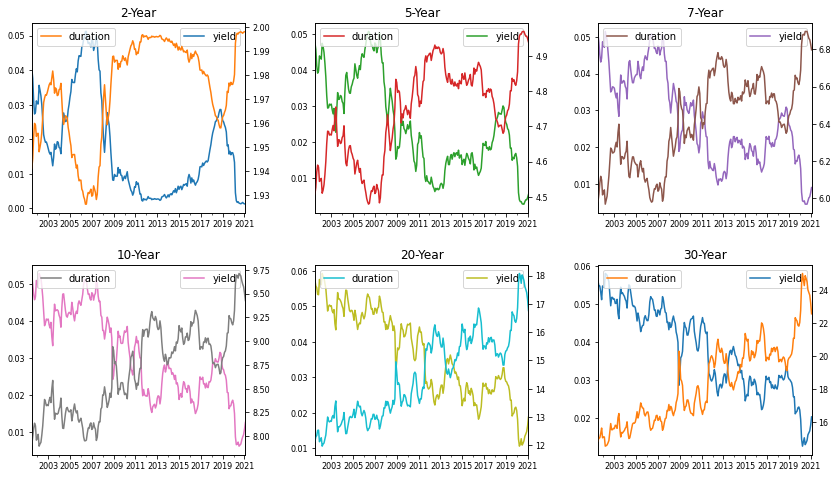

In [4]:
y = pd.concat([b[c*12].rename(c)/100 for c in [2,5,7,10,20,30]], axis=1)
y.index = pd.to_datetime(y.index, format='%Y%m%d')
d = pd.concat([y[c].apply(par_duration, n=c, m=2) for c in y], axis=1)
fig, axes = plt.subplots(2, 3, clear=True, num=1, figsize=(12,7))
for i in range(6):
    ax = axes[i // 3, i % 3]
    y.iloc[:, i].rename('yield').plot(ax=ax, c=f"C{i*2}",
                                      fontsize=8, legend=True,
                                      title=f"{y.columns[i]}-Year")
    bx = ax.twinx()
    d.iloc[:, i].rename('duration').plot(ax=bx, c=f"C{i*2+1}",
                                         fontsize=8, legend=True)
    ax.set_xlabel('')
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'term.jpg'))
plt.show()
    

## Interpolate yield curve spline as of a historical date
https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology

In [6]:
curve_date = 20021231
from scipy.interpolate import CubicSpline
yields = b.loc[curve_date].values
maturities = b.columns.to_list()
yield_curve = CubicSpline(maturities, yields, bc_type='clamped')

## Bootstrap nominal annual rates from interpolated ytm at semi-annual periods
 

In [7]:
ytm = [yield_curve(t) / 100 for t in range(6, 361, 6)]  
m = 2
nominal = np.array([])   # to store annualized rates from bootstrap
for y in ytm:
    nominal = np.append(nominal, bootstrap(y, nominal=nominal, m=m))

# Sanity-check results
for n in range(1, 1+len(ytm)):  # discounted cash flows all close to par=1
    assert(abs(dcf(ytm[n-1]/m, nominal[:n]/m) +
               pv(1, n=n, spot=nominal[n-1]/m) - 1) < 0.001)
f = np.array(forward(spot=nominal/m))  # as single-period rate
for n in range(1, 1+len(ytm)):  # compounded forwards all close to nominal
    assert(abs(np.prod(1 + f[:n]) - (1 + nominal[n-1] / m)**n) < 0.001)

## convert to annual effective rates

In [8]:
spot_rates = (((1 + np.array(nominal/2))**2) - 1) * 100
forward_rates = (((1 + np.array(f))**2) - 1) * 100
semi_annual = np.arange(6, 361, 6)     # enumerate semi-annual months

## Retrieve reconstructed yield curve history

https://sites.google.com/view/jingcynthiawu/yield-data

Yan Liu and Jing Cynthia Wu "Reconstructing the Yield Curve", Journal of Financial Economics, forthcoming.

https://drive.google.com/open?id=1_u9cRxmOSiwp_tFvlaORuhS-zwl935s0


In [10]:
def fetch_lw(file_id='1_u9cRxmOSiwp_tFvlaORuhS-zwl935s0'):
    src = "https://drive.google.com/uc?export=download&id={}".format(file_id)
    x = pd.ExcelFile(src)
    df = x.parse()
    dates = np.where(df.iloc[:, 0].astype(str).str[0].str.isdigit())[0]
    return DataFrame(np.exp(df.iloc[dates,1:361].astype(float).values/100) - 1,
                     index=to_monthend(df.iloc[dates, 0].values),
                     columns=np.arange(1, 361))
df = fetch_lw()
reconstructed_rates = df.loc[curve_date, :] * 100   # as of curve_date 20021231
df

,1,2,3,4,5,6,7,8,9,10,...,351,352,353,354,355,356,357,358,359,360
19610630,0.021146,0.022180,0.023157,0.024089,0.024987,0.025855,0.026683,0.027444,0.028105,0.028638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19610731,0.018148,0.019850,0.021342,0.022656,0.023822,0.024859,0.025771,0.026548,0.027178,0.027669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19610831,0.020431,0.021870,0.023238,0.024536,0.025749,0.026847,0.027795,0.028563,0.029151,0.029601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19610930,0.019961,0.021534,0.023035,0.024437,0.025694,0.026737,0.027507,0.028005,0.028320,0.028567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19611031,0.020009,0.021524,0.022990,0.024367,0.025604,0.026635,0.027417,0.027972,0.028382,0.028722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190831,0.020068,0.019866,0.019644,0.019418,0.019201,0.018995,0.018802,0.018617,0.018436,0.018253,...,0.020540,0.020544,0.020550,0.020557,0.020565,0.020576,0.020589,0.020605,0.020622,0.020641
20190930,0.017942,0.018108,0.018242,0.018337,0.018393,0.018414,0.018409,0.018381,0.018337,0.018280,...,0.022136,0.022143,0.022151,0.022161,0.022173,0.022187,0.022203,0.022222,0.022242,0.022264
20191031,0.015112,0.015252,0.015386,0.015507,0.015613,0.015702,0.015774,0.015830,0.015873,0.015905,...,0.022861,0.022867,0.022876,0.022887,0.022900,0.022915,0.022933,0.022953,0.022975,0.022999
20191130,0.015967,0.016030,0.016101,0.016175,0.016252,0.016328,0.016403,0.016478,0.016554,0.016628,...,0.023040,0.023044,0.023049,0.023055,0.023063,0.023073,0.023084,0.023097,0.023111,0.023128


## Plot historical reconstructed yield curve as 3D surface

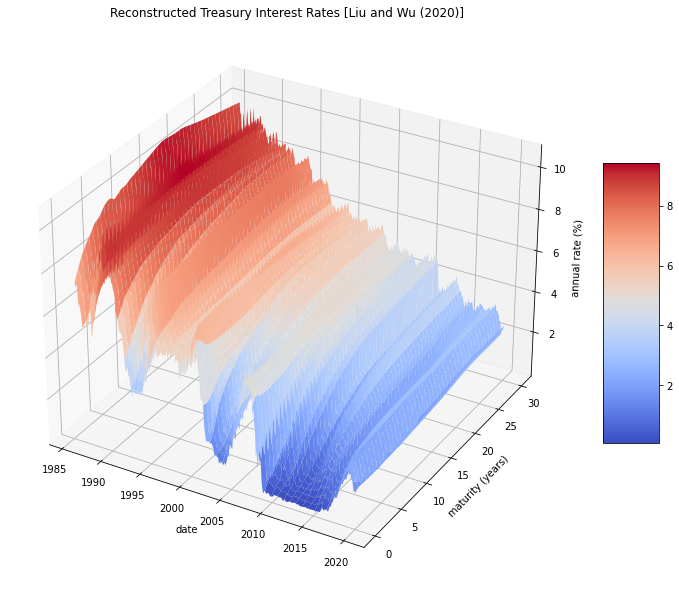

In [14]:
from mpl_toolkits.mplot3d import Axes3D
r = df.dropna()
X, Y = np.meshgrid((r.index//10000) + ((((r.index//100)%100)-1)/12),
                   r.columns.astype(float)/12)
Z = r.T.to_numpy()*100
fig = plt.figure(num=1, clear=True, figsize=(10,8))
ax = fig.gca(projection='3d')
f = ax.plot_surface(X, Y, Z, cmap='coolwarm', linewidth=0, antialiased=True)
ax.set_title('Reconstructed Treasury Interest Rates [Liu and Wu (2020)]')
ax.set_xlabel('date')
ax.set_ylabel('maturity (years)')
ax.set_zlabel('annual rate (%)')
fig.colorbar(f, shrink=0.5, aspect=5)
plt.tight_layout(pad=0)
plt.savefig(os.path.join(imgdir, 'reconstructed.jpg'))
plt.show()

## Plot yield curves

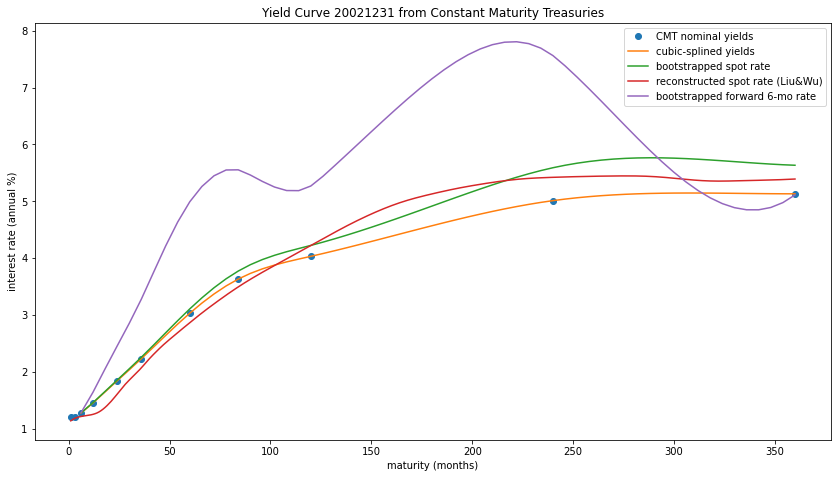

In [15]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(12,7))
ax.plot(maturities, yields, 'o', label='CMT nominal yields')
ax.plot(semi_annual, yield_curve(semi_annual), label="cubic-splined yields")
ax.plot(semi_annual, spot_rates, label="bootstrapped spot rate")
ax.plot(reconstructed_rates, label="reconstructed spot rate (Liu&Wu)")
ax.plot(semi_annual, forward_rates, label="bootstrapped forward 6-mo rate")
ax.set_title(f"Yield Curve {curve_date} from Constant Maturity Treasuries")
ax.set_xlabel('maturity (months)')
ax.set_ylabel('interest rate (annual %)')
ax.legend()
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'curve.jpg'))
plt.show()